Create a SNR MAP for SDP.81 MUSE data.

As recommended by Vorbin code by Cappellari, we compute the average of the flux in the wavelength range of interest as the signal, and for the noise we use the average of 1-sigma error in te same range (1-sigma error was obtined from variance present in the data cube.)
    
    To know,
$1\sigma = \sqrt{variance}$


The values of signal and noise are storage in the file __SNR.txt__, including its position (in pixel and wcs(rad)).

The final product is an .fits file with 2 ext, one wih the signal and the other with noise in each pixel.

In [46]:
from mpdaf.obj import Cube, Image
import numpy as np
import matplotlib.pyplot as plt

data_folder = "/home/carlos/Desktop/pPXF(SDP)/"

In [47]:
img = Image(data_folder+"Data/Muse_Image.fits")

 [astropy.io.fits.verify]


In [48]:
img.var = img.data.copy()  #Create a new extension to store the Noise 

In [49]:
#Load table with snr
y_px, x_px, y_wcs, x_wcs, signal, noise = np.loadtxt("SNRFull.txt", unpack=True)

In [50]:
#Wrtite signal in the data ext of img, and noise in the variance ext

for i in range(len(y_px)):                                       #Running all pixels
    img.data.data[int(y_px[i])][int(x_px[i])] = signal[i]
    img.var.data[int(y_px[i])][int(x_px[i])]  = noise[i]

In [51]:
#Saving Signal and Noise in different extensions 
img.write(data_folder+"Data/FullSpec_Data/Full_Signal_and_Noise.fits")

In [52]:
#Creating a SNR map
img.data.data[:]    = img.data.data/img.var.data
img.var.data[:]     = np.nan
img.write(data_folder+"Data/FullSpec_Data/SNRFull_map.fits")

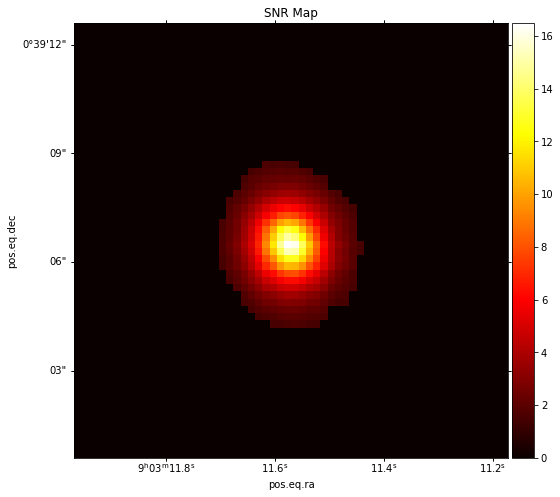

In [53]:
plt.figure(figsize=(10,8))
(img * (img.data.data > 1.5)).plot(use_wcs=True, colorbar="v",cmap="hot", title="SNR Map")
#plt.savefig(data_folder+"Images/SNR_Map_above_1.png")

Now we create a table with postion and value of signal/noise above 1.

This table will be used for Voronoi Binnning and Annealing Binning.

In [54]:
#Reading the snr again
snr = np.loadtxt('SNRFull.txt')

In [55]:
threshold = 1.5      #Select minimum snr value

x = []
y = []
signal = []
noise = []
for i in range(len(snr)):
    if snr[i][4]/snr[i][5] >= threshold:
        if snr[i][0] < 45:               #Excluding pxs far from galaxy
            x.append(snr[i][1])
            y.append(snr[i][0])
            signal.append(snr[i][4])
            noise.append(snr[i][5])

print(len(signal)) #Total spaxel above 1.
#Save table with this spaxel positions

np.savetxt('GoodPixelsFull.txt',np.column_stack([y, x, signal, noise]), header='y_px x_px signal noise')

352


## Fits File with GoodPixels

In [56]:
img = Image(data_folder+"Data/Muse_Image.fits") #Load cut data image where we will store the GoodPixels

 [astropy.io.fits.verify]


In [57]:
y, x, signal, noise = np.loadtxt("GoodPixelsFull.txt", unpack=True) #Read the table with pixel above snr = 1

In [58]:
img.data.data[:] = 0                                  #For all pixel in the image we atribute zero

for i in range(len(y)):                               #For pixels above the threshold we give its signal
    img.data.data[int(y[i])][int(x[i])] = signal[i]

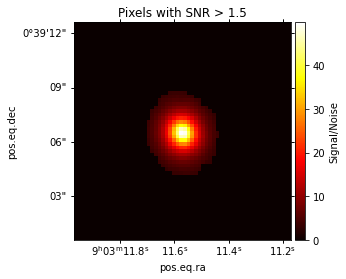

In [61]:
#Plot and save result

plot = img.plot(use_wcs=True, cmap='hot', colorbar='v', title="Pixels with SNR > 1.5")
plot.colorbar.set_label('Signal/Noise')
img.write(data_folder+"Data/FullSpec_Data/SNRFull_selected.fits")
#plt.savefig("/home/carlos/Desktop/SDP/Dynamics/pPXF/Figs/GoodPixels.png",format='png')